In [1]:
%pip install sortedcontainers
%pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.



In [2]:
#import das bibliotecas necessárias
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from functools import cmp_to_key
from sortedcontainers import SortedList
from ucimlrepo import fetch_ucirepo 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [3]:
def orientation(p, q, r):
    """
    Determina a orientação do trio ordenado (p, q, r).
    Se o resultado for 0, então colinear
    Se for 1, então horário
    Se for -1, então anti-horário
    """
    val = (q.y - p.y) * (r.x - q.x) - (q.x - p.x) * (r.y - q.y)
    if val == 0:
        return 0
    return 1 if val > 0 else -1


def on_segment(p, q, r):
    """
    Verifica se o ponto q está no segmento pr
    """
    return (q.x <= max(p.x, r.x) and q.x >= min(p.x, r.x) and 
            q.y <= max(p.y, r.y) and q.y >= min(p.y, r.y))


In [4]:
class Ponto:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __sub__(self, other):
        return Ponto(self.x - other.x, self.y - other.y)

    def __repr__(self):
        return f"({self.x}, {self.y})"

    def distancia_ao_quadrado(self, other):
        return (self.x - other.x)**2 + (self.y - other.y)**2

class Segmento:
    def __init__(self, p1, p2):
        self.p1 = p1
        self.p2 = p2
    def __repr__(self):
        return f"[{self.p1}, {self.p2}]"
    
    def __hash__(self):
        return hash((self.p1, self.p2))
    
    def __eq__(self, other):
        return isinstance(other, Segmento) and {self.p1, self.p2} == {other.p1, other.p2}
    
    def intersecao(self, other):
        o1 = orientation(self.p1, self.p2, other.p1)
        o2 = orientation(self.p1, self.p2, other.p2)
        o3 = orientation(other.p1, other.p2, self.p1)
        o4 = orientation(other.p1, other.p2, self.p2)

        # Condições principais de interseção
        if o1 * o2 < 0 and o3 * o4 < 0:
            return True

        # Casos especiais: se os segmentos são colineares e se cruzam
        if o1 == 0 and on_segment(self.p1, other.p1, self.p2):
            return True
        if o2 == 0 and on_segment(self.p1, other.p2, self.p2):
            return True
        if o3 == 0 and on_segment(other.p1, self.p1, other.p2):
            return True
        if o4 == 0 and on_segment(other.p1, self.p2, other.p2):
            return True

        return False

    
    def produto_vetorial(self, other):
        return (self.p2.x - self.p1.x) * (other.p2.y - other.p1.y) - (self.p2.y - self.p1.y) * (other.p2.x - other.p1.x)
    
    def __lt__(self, other):
        return self.p1.y < other.p1.y or (self.p1.y == other.p1.y and self.p2.y < other.p2.y)

class Event:
    def __init__(self, x, y, segment, is_start, poligono):
        self.x = x
        self.y = y
        self.segment = segment
        self.is_start = is_start
        self.poligono = poligono

    def __lt__(self, other):
        if self.x != other.x:
            return self.x < other.x
        return self.y < other.y

In [5]:
def ordenacao_polar(p0):
    def compare(p1, p2):
        o = orientation(p0, p1, p2)
        if o == 0:
            if p1.distancia_ao_quadrado(p0) < p2.distancia_ao_quadrado(p0):
                return -1
            else:
                return 1
        return 1 if o > 0 else -1
    return compare


In [6]:
#Algoritmo de Graham Scan para criar a envoltoŕia convexa

def graham_scan(pontos):
    if len(pontos) < 3:
        return pontos  # Retorna os pontos originais se houver menos de 3

    pontos = sorted(pontos, key=lambda p: (p.y, p.x))
    p0 = pontos[0]
    pontos_ordenados = sorted(pontos[1:], key=cmp_to_key(ordenacao_polar(p0)))

    envoltoria = [p0, pontos_ordenados[0]]
    for p in pontos_ordenados[1:]:
        while len(envoltoria) > 1 and Segmento(envoltoria[-2], envoltoria[-1]).produto_vetorial(Segmento(envoltoria[-1], p)) <= 0:
            envoltoria.pop()
        envoltoria.append(p)

    if len(envoltoria) > 2:
        envoltoria.append(p0)

    return envoltoria


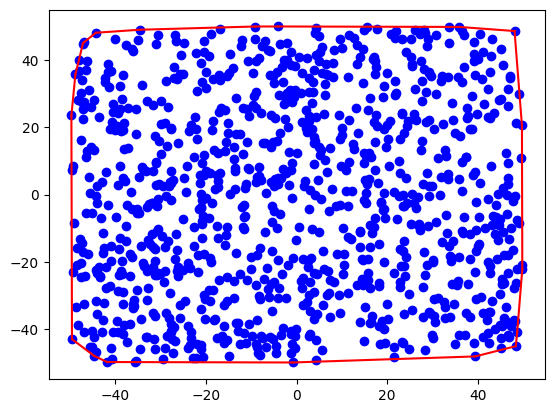

In [7]:
# Função para plotar a envoltória convexa

def plot_envoltoria(pontos, envoltoria):
    # Plotar todos os pontos
    plt.scatter([p.x for p in pontos], [p.y for p in pontos], color='b')

    # Plotar a envoltória convexa
    for i in range(len(envoltoria) - 1):
        plt.plot([envoltoria[i].x, envoltoria[i+1].x], [envoltoria[i].y, envoltoria[i+1].y], color='r')
    
    # Fechar a envoltória
    plt.plot([envoltoria[-1].x, envoltoria[0].x], [envoltoria[-1].y, envoltoria[0].y], color='r')
    
    plt.show()

# Gerar pontos aleatórios para testar o algoritmo e posteriormente plotar a envoltória convexa
pontos = [Ponto(random.uniform(-50, 50), random.uniform(-50, 50)) for _ in range(1000)]
envoltoria = graham_scan(pontos)
plot_envoltoria(pontos, envoltoria)

In [8]:
def cruzam(seg1, seg2):
    """ Verifica se os segmentos seg1 e seg2 se cruzam """
    # Usa sua função 'intersecao' já definida anteriormente
    return seg1.intersecao(seg2)


def segmentos_que_se_cruzam(segmentos, poligonos):
    segmento_para_poligono = {seg: pol for seg, pol in zip(segmentos, poligonos)}
    
    eventos = []
    for seg in segmentos:
        start = seg.p1 if seg.p1.x < seg.p2.x else seg.p2
        end = seg.p2 if seg.p1.x < seg.p2.x else seg.p1
        eventos.append((start, 'start', seg))
        eventos.append((end, 'end', seg))
    
    eventos.sort(key=lambda e: (e[0].x, e[0].y))

    # Usando SortedList da biblioteca sortedcontainers que é eficiente
    active_segments = SortedList(key=lambda s: (s.p1.y + s.p2.y) / 2)
    intersecoes = set()

    for ponto, tipo, segmento in eventos:
        if tipo == 'start':
            idx = active_segments.bisect(segmento)

            # Verificar interseção com segmento abaixo
            if idx > 0 and segmento.intersecao(active_segments[idx - 1]) and segmento_para_poligono[segmento] != segmento_para_poligono[active_segments[idx - 1]]:
                intersecoes.add(tuple(sorted([segmento, active_segments[idx - 1]])))

            # Verificar interseção com segmento acima
            if idx < len(active_segments) and segmento.intersecao(active_segments[idx]) and segmento_para_poligono[segmento] != segmento_para_poligono[active_segments[idx]]:
                intersecoes.add(tuple(sorted([segmento, active_segments[idx]])))

            active_segments.add(segmento)
        else:
            if segmento in active_segments:
                segmento_idx = active_segments.index(segmento)

                # Verificar interseção entre segmentos vizinhos
                if 0 < segmento_idx < len(active_segments) - 1:
                    seg_below = active_segments[segmento_idx - 1]
                    seg_above = active_segments[segmento_idx + 1]
                    if seg_below.intersecao(seg_above) and segmento_para_poligono[seg_below] != segmento_para_poligono[seg_above]:
                        intersecoes.add(tuple(sorted([seg_below, seg_above])))

                active_segments.remove(segmento)
    
    return list(intersecoes)


In [9]:
def verificar_separabilidade_linear(classe_1, classe_2):
    envoltoria_classe_1 = graham_scan(classe_1)
    envoltoria_classe_2 = graham_scan(classe_2)

    segmentos_classe_1 = [Segmento(envoltoria_classe_1[i], envoltoria_classe_1[i + 1]) for i in range(len(envoltoria_classe_1) - 1)]
    segmentos_classe_2 = [Segmento(envoltoria_classe_2[i], envoltoria_classe_2[i + 1]) for i in range(len(envoltoria_classe_2) - 1)]

    todos_os_segmentos = segmentos_classe_1 + segmentos_classe_2
    poligonos = [1] * len(segmentos_classe_1) + [2] * len(segmentos_classe_2)

    intersecoes = segmentos_que_se_cruzam(todos_os_segmentos, poligonos)
    return len(intersecoes) == 0


In [10]:
def plot_separabilidade(classe_1, classe_2):

    classe_1 = graham_scan(classe_1)
    classe_2 = graham_scan(classe_2)
    print(classe_1)
    print(classe_2)

    # Verificar se os dados são linearmente separáveis
    separaveis = verificar_separabilidade_linear(classe_1, classe_2)
    
    # Plotar envoltória da classe 1
    for i in range(len(classe_1) - 1):
        plt.plot([classe_1[i].x, classe_1[i + 1].x], 
                 [classe_1[i].y, classe_1[i + 1].y], 'b-')
    
    # Plotar envoltória da classe 2
    for i in range(len(classe_2) - 1):
        plt.plot([classe_2[i].x, classe_2[i + 1].x], 
                 [classe_2[i].y, classe_2[i + 1].y], 'r-')
    
    if separaveis:
        plt.title("Dados são linearmente separáveis!")
    else:
        plt.title("Dados não são linearmente separáveis!")
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

[(4, 2), (3, 9)]
[(14, 11), (10, 14), (11, 13), (14, 11)]


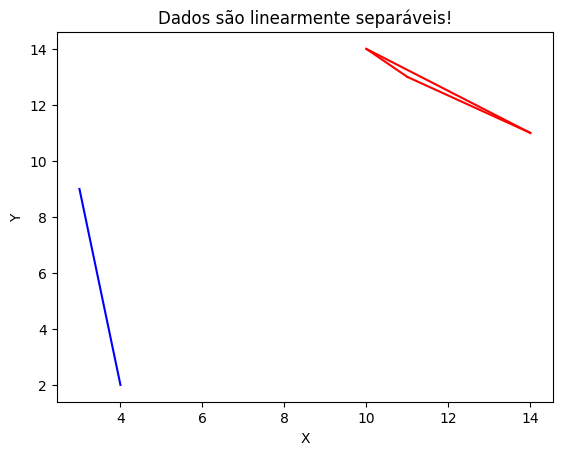

In [11]:
# Gerar pontos aleatórios para ambas as classes
classe_1_random = [Ponto(random.randint(0, 10), random.randint(0, 10)) for _ in range(2)]
classe_2_random = [Ponto(random.randint(5, 15), random.randint(5, 15)) for _ in range(3)]

plot_separabilidade(classe_1_random, classe_2_random)

In [12]:
def encontrar_pontos_mais_proximos(env1, env2):
    menor_distancia = float('inf')
    ponto1 = None
    ponto2 = None

    for p1 in env1:
        for p2 in env2:
            distancia = p1.distancia_ao_quadrado(p2)
            if distancia < menor_distancia:
                menor_distancia = distancia
                ponto1 = p1
                ponto2 = p2

    return ponto1, ponto2

def construir_modelo_linear(pontos1, pontos2):
    env1 = graham_scan(pontos1)
    env2 = graham_scan(pontos2)

    if not verificar_separabilidade_linear(env1, env2):
        print('Os dados não são linearmente separáveis.')
        return None

    ponto1, ponto2 = encontrar_pontos_mais_proximos(env1, env2)

    ponto_medio = Ponto((ponto1.x + ponto2.x) / 2, (ponto1.y + ponto2.y) / 2)
    vetor_direcao = Ponto(ponto2.x - ponto1.x, ponto2.y - ponto1.y)
    vetor_direcao_perpendicular = Ponto(vetor_direcao.y, -vetor_direcao.x)

    if vetor_direcao_perpendicular.x == 0:
        return 'vertical', ponto_medio.x, env1, env2
    else:
        m = vetor_direcao_perpendicular.y / vetor_direcao_perpendicular.x
        b = ponto_medio.y - m * ponto_medio.x
        return m, b, env1, env2

def plot_modelo(pontos1, pontos2):
    resultado = construir_modelo_linear(pontos1, pontos2)

    if resultado is None:
        return None
    
    modelo, b, env1, env2 = resultado

    ponto1, ponto2 = encontrar_pontos_mais_proximos(env1, env2)
    plt.fill([p.x for p in env1], [p.y for p in env1], color='blue', alpha=0.3)
    plt.fill([p.x for p in env2], [p.y for p in env2], color='red', alpha=0.3)
    plt.plot([p.x for p in env1 + [env1[0]]], [p.y for p in env1 + [env1[0]]], 'b-')
    plt.plot([p.x for p in env2 + [env2[0]]], [p.y for p in env2 + [env2[0]]], 'r-')
    plt.plot([ponto1.x, ponto2.x], [ponto1.y, ponto2.y], 'g--')
    
    if modelo == 'vertical':
        plt.axvline(x=b, color='c', label='Modelo Linear')
    else:
        m = modelo
        x_vals = [min([p.x for p in env1 + env2]), max([p.x for p in env1 + env2])]
        y_vals = [m*x+b for x in x_vals]
        plt.plot(x_vals, y_vals, 'c-', label='Modelo Linear')

    # Ajuste a escala dos eixos x e y conforme necessário
    # Defina os limites x e y para ajustar a escala do gráfico
    plt.xlim(min([p.x for p in env1 + env2]) - 1, max([p.x for p in env1 + env2]) + 1)
    plt.ylim(min([p.y for p in env1 + env2]) - 1, max([p.y for p in env1 + env2]) + 1)

    plt.legend()
    plt.show()


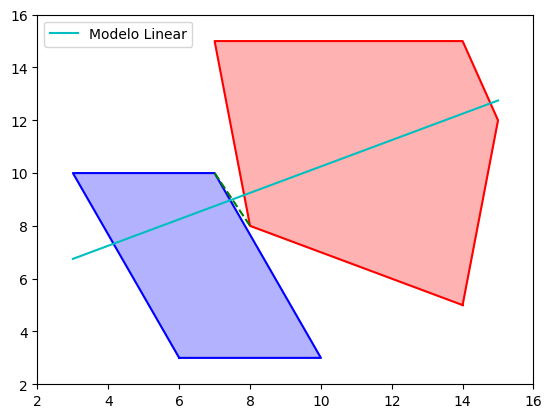

In [13]:
# Gerar pontos aleatórios para testar
classe_1 = [Ponto(random.randint(0, 10), random.randint(0, 10)) for _ in range(5)]
classe_2 = [Ponto(random.randint(5, 15), random.randint(5, 15)) for _ in range(5)]

plot_modelo(classe_1, classe_2)

In [14]:
def classificar_pontos_teste(ponto, modelo):
    if modelo[0] == 'vertical':
        return 1 if ponto.x > modelo[1] else 2
    else:
        y_modelo = modelo[0] * ponto.x + modelo[1]
        return 1 if ponto.y >= y_modelo else 2

def calcular_metricas_teste(pontos1, pontos2, modelo):
    VP = sum(1 for ponto in pontos1 if classificar_pontos_teste(ponto, modelo) == 1)
    FN = len(pontos1) - VP

    VN = sum(1 for ponto in pontos2 if classificar_pontos_teste(ponto, modelo) == 2)
    FP = len(pontos2) - VN

    precisao = VP / (VP + FP) if (VP + FP) != 0 else 0
    revocacao = VP / (VP + FN) if (VP + FN) != 0 else 0
    f1_score = 2 * (precisao * revocacao) / (precisao + revocacao) if (precisao + revocacao) != 0 else 0

    return precisao, revocacao, f1_score

def plotar_classificacao(pontos1, pontos2):
    # Extrair coordenadas x e y dos pontos para plotagem
    modelo = construir_modelo_linear(pontos1, pontos2)
    if modelo is None:
        return [],[]
    
    x1, y1 = zip(*[(p.x, p.y) for p in pontos1])
    x2, y2 = zip(*[(p.x, p.y) for p in pontos2])
    
    # Plotar os pontos
    plt.scatter(x1, y1, color='blue', label='Classe 1')
    plt.scatter(x2, y2, color='red', label='Classe 2')
    
    # Plotar a reta do modelo
    if modelo[0] == 'vertical':
        plt.axvline(x=modelo[1], color='green', linestyle='--', label='Reta do Modelo')
    else:
        # Criando uma sequência de valores x para a reta
        x_reta = list(range(int(min(x1 + x2)) - 1, int(max(x1 + x2)) + 2))
        y_reta = [modelo[0] * x + modelo[1] for x in x_reta]
        
        plt.plot(x_reta, y_reta, color='green', linestyle='--', label='Reta do Modelo')
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.title('Classificação de Pontos com Modelo Linear')
    plt.grid(True)
    plt.show()
    

In [15]:
def gerar_pontos_aleatorios(qtd_pontos, limite_inf, limite_sup):
    """
    Gera uma lista de pontos aleatórios.
    
    :param qtd_pontos: Número de pontos a serem gerados.
    :param limite_inf: Tuple contendo os limites inferiores (x, y).
    :param limite_sup: Tuple contendo os limites superiores (x, y).
    :return: Lista de pontos aleatórios.
    """
    pontos = []
    for _ in range(qtd_pontos):
        x = random.uniform(limite_inf[0], limite_sup[0])
        y = random.uniform(limite_inf[1], limite_sup[1])
        pontos.append(Ponto(x, y))
    return pontos


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def apply_tsne(data, labels=list):
    # Normalizar os dados
    scaler = StandardScaler()
    data_normalized = scaler.fit_transform(data)


    """
    Aplica a redução de dimensionalidade t-SNE em um conjunto de dados.

    Parâmetros:
    - data (pandas DataFrame): Dados a serem reduzidos.
    - labels (pandas Series, opcional): Etiquetas para colorir os pontos.

    Retorna:
    - data_tsne (pandas DataFrame): DataFrame com as duas componentes do t-SNE.
    """
    tsne = TSNE(n_components=2, random_state=42)
    data_tsne = tsne.fit_transform(data_normalized)
    
    if labels is not None:
        unique_labels = sorted(labels.unique())
        colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

        for color, label in zip(colors, unique_labels):
            mask = labels == label
            plt.scatter(data_tsne[mask, 0], data_tsne[mask, 1], color=color, alpha=0.7, label=str(label))

    data_tsne_df = pd.DataFrame(data=data_tsne, columns=['Componente 1', 'Componente 2'])
    
    return data_tsne_df


In [17]:
from ucimlrepo import fetch_ucirepo 

# fetch dataset 
iris = fetch_ucirepo(id=53) 
  
# data (as pandas dataframes) 
x = iris.data.features 
y = iris.data.targets 

irisData = pd.concat([x, y], axis=1)
irisData.head()

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [18]:

irisTest = irisData.sample(frac = 0.3)
irisTrain = irisData.drop(irisTest.index)

versicolor = irisTrain[irisTrain['class'] == 'Iris-versicolor']

versicolor = versicolor.drop(labels=['sepal width', 'petal width'], axis=1)
versicolor.head(5)

setosa= irisTrain[irisTrain['class'] == 'Iris-setosa']
setosa = setosa.drop(labels=['sepal width', 'petal width'], axis=1)
setosa.head(5)
    


,sepal length,petal length,class
0,5.1,1.4,Iris-setosa
1,4.9,1.4,Iris-setosa
2,4.7,1.3,Iris-setosa
5,5.4,1.7,Iris-setosa
6,4.6,1.4,Iris-setosa


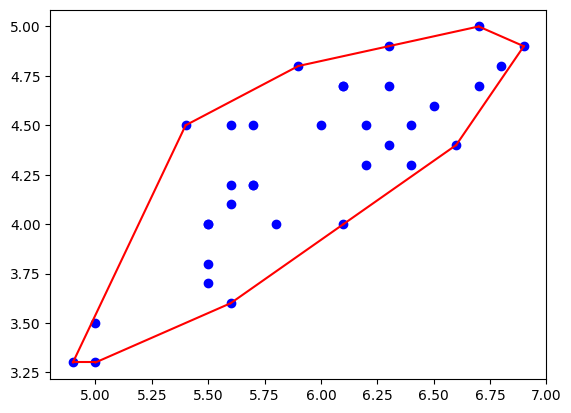

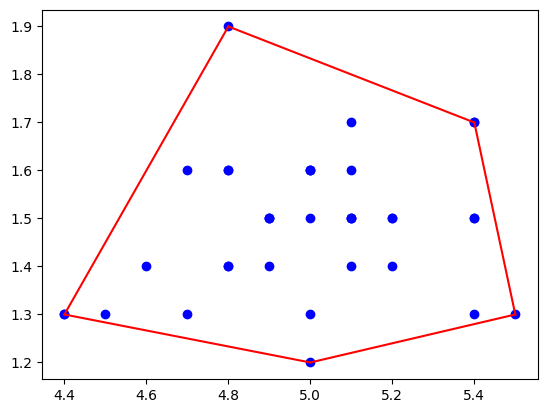

In [19]:
pointsVersicolor = [Ponto(row['sepal length'], row['petal length']) for index, row in versicolor.iterrows()]

versicolorEnv = graham_scan(pointsVersicolor)
plot_envoltoria(pointsVersicolor, versicolorEnv)

pointsSetosa = [Ponto(row['sepal length'], row['petal length']) for index, row in setosa.iterrows()]
setosaEnv = graham_scan(pointsSetosa)
plot_envoltoria(pointsSetosa, setosaEnv)

[(4.9, 3.3), (5.0, 3.3), (5.6, 3.6), (6.1, 4.0), (6.6, 4.4), (6.9, 4.9), (6.7, 5.0), (6.3, 4.9), (5.9, 4.8), (5.4, 4.5), (4.9, 3.3)]
[(5.0, 1.2), (5.5, 1.3), (5.4, 1.7), (4.8, 1.9), (4.4, 1.3), (5.0, 1.2)]


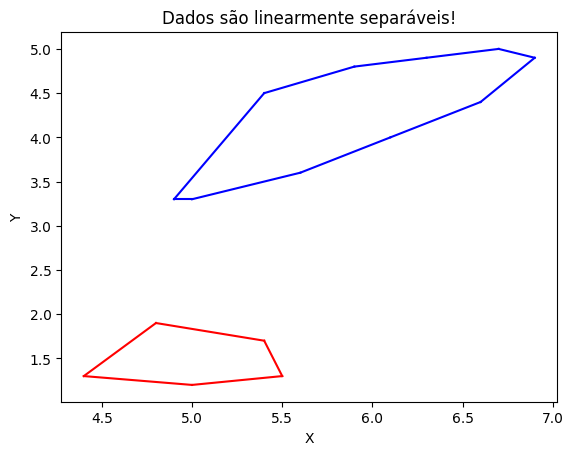

In [20]:
verificar_separabilidade_linear(versicolorEnv, setosaEnv)
plot_separabilidade(pointsVersicolor, pointsSetosa)

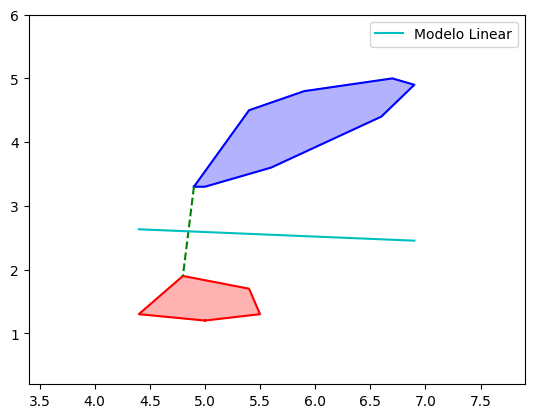

In [21]:
modelo = construir_modelo_linear(pointsVersicolor, pointsSetosa)
plot_modelo(pointsVersicolor, pointsSetosa)

In [22]:
precisao, revocacao, f1 = calcular_metricas_teste(pointsVersicolor, pointsSetosa, modelo)
print(f"Precisão: {precisao:.2f}")
print(f"Revocação: {revocacao:.2f}")
print(f"F1-score: {f1:.2f}")

Precisão: 1.00
Revocação: 1.00
F1-score: 1.00


In [23]:
def apply_pca(data, n_components=2):
    # Normaliza os dados
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(data)
    
    # Aplica PCA
    pca = PCA(n_components=n_components)
    reduced_data = pca.fit_transform(normalized_data)
    
    return pd.DataFrame(reduced_data, columns=[f'Componente {i+1}' for i in range(n_components)])

In [24]:
def prever(modelo, ponto, positive_label, negative_label):
    m, c = modelo[:2]
    if ponto.y > m * ponto.x + c:
        return positive_label
    else:
        return negative_label

def calcular_metricas(label_name, test, modelo, positive_label, negative_label):
    verdadeiros = test[label_name].tolist()
    previstos = [prever(modelo, Ponto(row['Componente 1'], row['Componente 2']), positive_label, negative_label) for _, row in test.iterrows()]
    
    tp = sum(1 for v, p in zip(verdadeiros, previstos) if v == positive_label and p == positive_label)
    fp = sum(1 for v, p in zip(verdadeiros, previstos) if v == negative_label and p == positive_label)
    fn = sum(1 for v, p in zip(verdadeiros, previstos) if v == positive_label and p == negative_label)
    
    precisao = tp / (tp + fp) if tp + fp != 0 else 0
    revocacao = tp / (tp + fn) if tp + fn != 0 else 0
    f1 = 2 * (precisao * revocacao) / (precisao + revocacao) if (precisao + revocacao) != 0 else 0
    
    return precisao, revocacao, f1


# Testando com PCA e aninhando

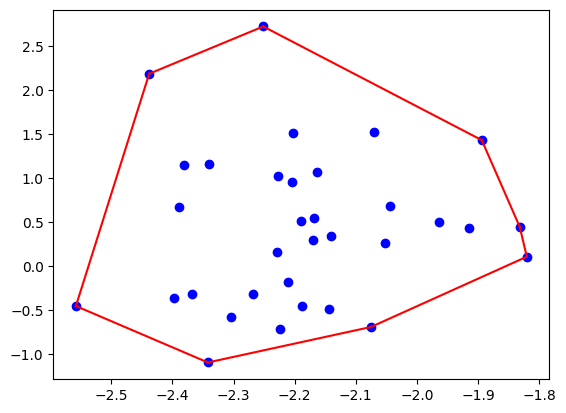

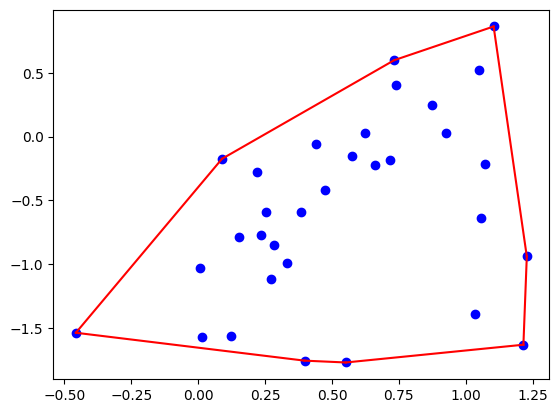

[(-2.341957676455392, -1.0951463625829554), (-2.0753575928373076, -0.6919173471364096), (-1.8204115633372144, 0.106750792835407), (-1.8319381022015873, 0.4452668355028082), (-1.8940742930236678, 1.431110706941238), (-2.251465214584064, 2.7223710765744715), (-2.4379508590951415, 2.185391615630894), (-2.5578344195375142, -0.4538163804897926), (-2.341957676455392, -1.0951463625829554)]
[(0.551633981422507, -1.772581564856256), (1.2153032092161533, -1.6333556445154838), (1.2279882140834424, -0.9409147925302733), (1.1039936528045737, 0.8631124458513243), (0.7324814400086813, 0.5986355733419974), (0.08905311031901122, -0.17490854779054194), (-0.45701287250467615, -1.5394645102639815), (0.3973072828233262, -1.7581689474435271), (0.551633981422507, -1.772581564856256)]


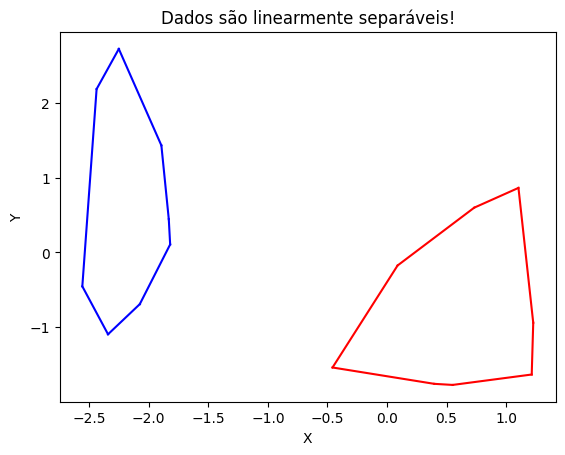

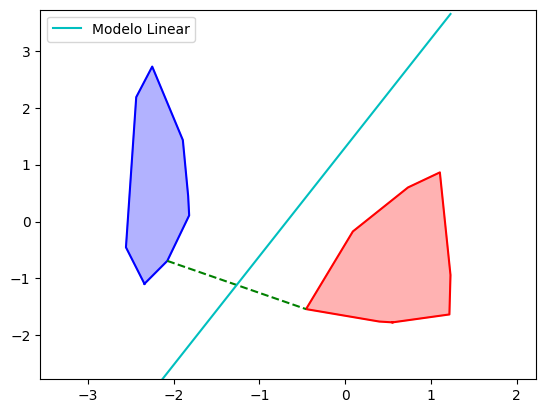

Precisão: 1.00
Revocação : 0.94
F1-score: 0.97


In [52]:
# Aplicando PCA
irisPCA = apply_pca(irisData.drop(labels=['class'], axis=1))
irisPCA['class'] = irisData['class']

irisTest = irisPCA.sample(frac = 0.3)
irisTrain = irisPCA.drop(irisTest.index)

# Acessando as classes separadamente com base na coluna 'class'
irisTrain0 = irisTrain[irisTrain['class'] == 'Iris-setosa']
irisTrain1 = irisTrain[irisTrain['class'] == 'Iris-versicolor']

# Convertendo para pontos
irisTrain0Pts = [Ponto(row['Componente 1'], row['Componente 2']) for _, row in irisTrain0.iterrows()]
irisTrain1Pts = [Ponto(row['Componente 1'], row['Componente 2']) for _, row in irisTrain1.iterrows()]

# Plotando o casco convexo
irisTrain0Env = graham_scan(irisTrain0Pts)
plot_envoltoria(irisTrain0Pts, irisTrain0Env)

irisTrain1Env = graham_scan(irisTrain1Pts)
plot_envoltoria(irisTrain1Pts, irisTrain1Env)

separavel = verificar_separabilidade_linear(irisTrain0Env, irisTrain1Env)
plot_separabilidade(irisTrain0Pts, irisTrain1Pts)

modelo = construir_modelo_linear(irisTrain0Pts, irisTrain1Pts)
if (modelo):
    plot_modelo(irisTrain0Pts, irisTrain1Pts)
    label_iris = 'class'
    precisao, revocacao, f1 = calcular_metricas(label_iris, irisTest, modelo, positive_label='Iris-setosa', negative_label='Iris-versicolor')
    print(f"Precisão: {precisao:.2f}")
    print(f"Revocação : {revocacao:.2f}")
    print(f"F1-score: {f1:.2f}")

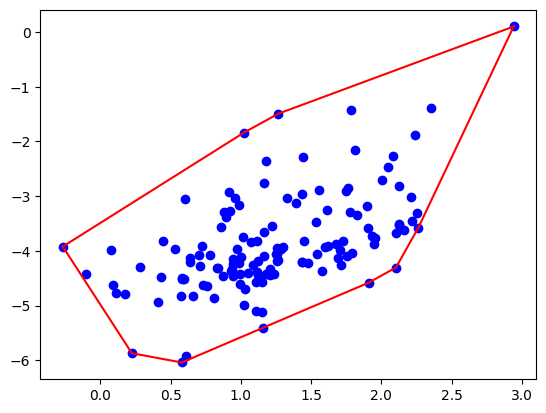

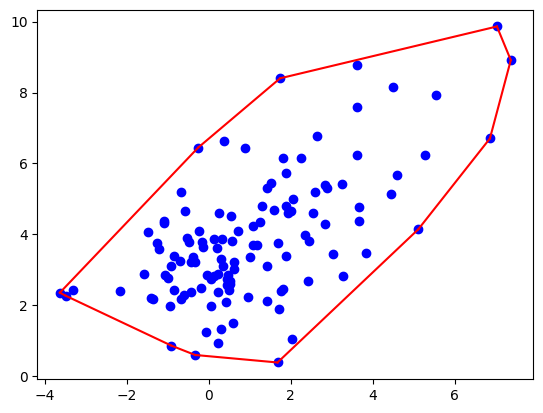

[(0.5792236944371157, -6.0393295849068735), (1.9108354143236304, -4.5799038836665416), (2.10413874772844, -4.304002651917178), (2.2640548975358, -3.5728497736650624), (2.9422023701000533, 0.10077609209791466), (1.2676788797626073, -1.491650952668503), (1.022120491731853, -1.8388583105781988), (-0.2675246919245575, -3.9212438124128215), (0.22441361988089495, -5.8702885719877616), (0.5792236944371157, -6.0393295849068735)]
[(1.6817070867140762, 0.3912635602685977), (5.114918597280658, 4.143988009857524), (6.862745729662772, 6.704680733163036), (7.372240509463626, 8.912590889753508), (7.033570116177272, 9.861031792286768), (1.7437238217626718, 8.399924308772297), (-0.25222052308569337, 6.4494342650252054), (-3.6271977950703933, 2.358800959896113), (-3.4837924641365885, 2.2709686016995505), (-0.9113081472044507, 0.8675999543935892), (-0.3280878969037858, 0.6026478422356017), (1.6817070867140762, 0.3912635602685977)]


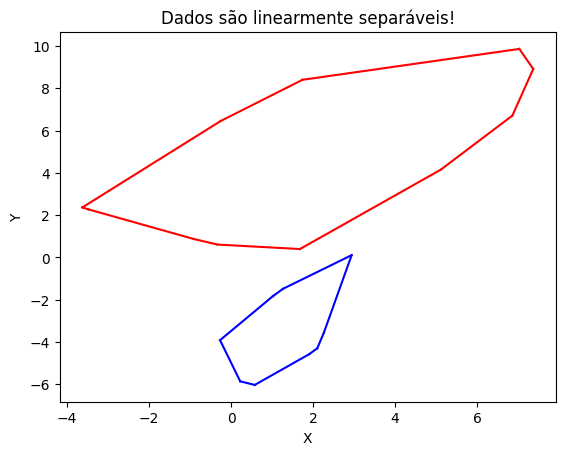

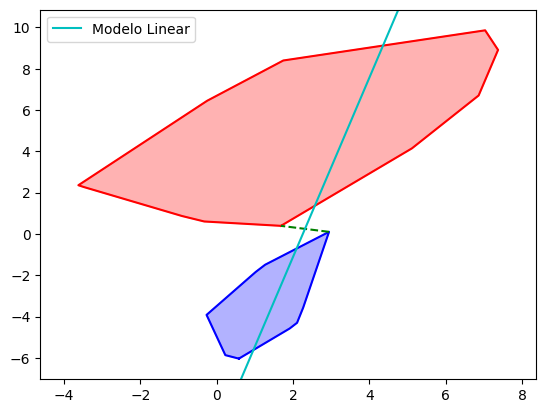

Precisão: 0.44
Revocação: 0.64
F1-score: 0.52


In [56]:
from sklearn.datasets import load_digits
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

digits = load_digits()
data = pd.DataFrame(digits.data)
data['label'] = digits.target

# Aplicando PCA
digitsPCA = apply_pca(data.drop(labels=['label'], axis=1))
digitsPCA['label'] = data['label']

digitsTest = digitsPCA.sample(frac = 0.3)
digitsTrain = digitsPCA.drop(digitsTest.index)

# Acessando as classes separadamente com base na coluna 'label'
digitsTrain4 = digitsTrain[digitsTrain['label'] == 6]
digitsTrain3 = digitsTrain[digitsTrain['label'] == 7]

# Convertendo para pontos
digitsTrain4Pts = [Ponto(row['Componente 1'], row['Componente 2']) for _, row in digitsTrain4.iterrows()]
digitsTrain3Pts = [Ponto(row['Componente 1'], row['Componente 2']) for _, row in digitsTrain3.iterrows()]

# Plotando o casco convexo
digitsTrain4Env = graham_scan(digitsTrain4Pts)
plot_envoltoria(digitsTrain4Pts, digitsTrain4Env)

digitsTrain3Env = graham_scan(digitsTrain3Pts)
plot_envoltoria(digitsTrain3Pts, digitsTrain3Env)

separavel = verificar_separabilidade_linear(digitsTrain4Env, digitsTrain3Env)
plot_separabilidade(digitsTrain4Pts, digitsTrain3Pts)

modelo = construir_modelo_linear(digitsTrain4Pts, digitsTrain3Pts)
if (modelo):
    plot_modelo(digitsTrain4Pts, digitsTrain3Pts)
    label_digits = 'label'
    precisao, revocacao, f1 = calcular_metricas(label_digits, digitsTrain, modelo, positive_label=6, negative_label=7)  # Note que corrigi os labels
    print(f"Precisão: {precisao:.2f}")
    print(f"Revocação: {revocacao:.2f}")
    print(f"F1-score: {f1:.2f}")


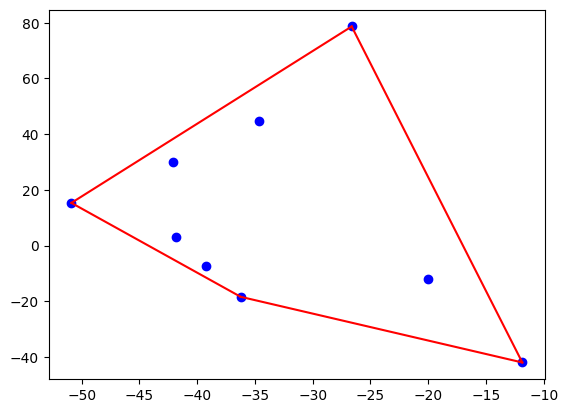

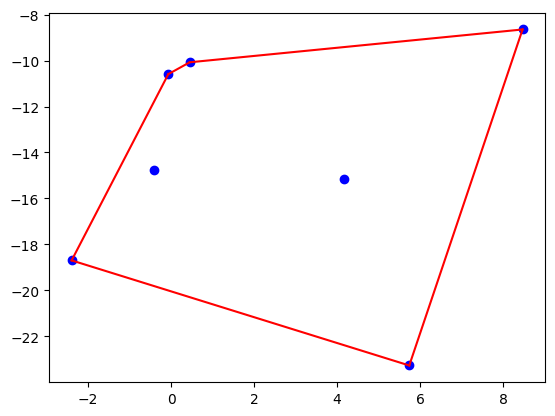

[(-11.859996795654297, -41.95490264892578), (-26.628353118896484, 78.67497253417969), (-50.89072799682617, 15.336922645568848), (-36.239376068115234, -18.376853942871094), (-11.859996795654297, -41.95490264892578)]
[(5.739462375640869, -23.26615333557129), (8.468461036682129, -8.648137092590332), (0.45026636123657227, -10.075637817382812), (-0.06486941874027252, -10.59054946899414), (-2.3937904834747314, -18.69497299194336), (5.739462375640869, -23.26615333557129)]


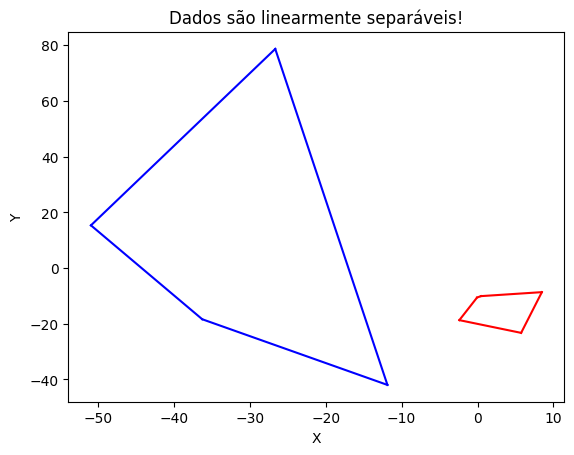

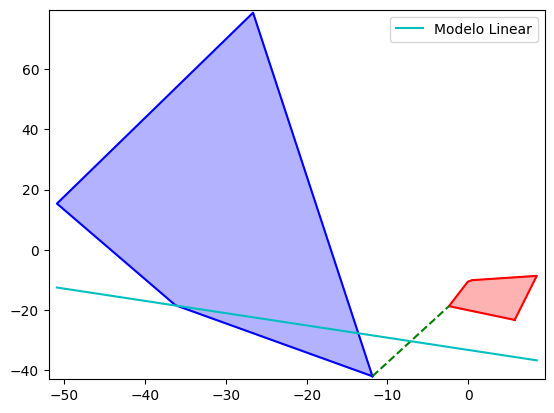

Precisão: 0.25
Revocação: 1.00
F1-score: 0.40


In [58]:
from sklearn.datasets import fetch_olivetti_faces

faces = fetch_olivetti_faces(shuffle=True)
data = pd.DataFrame(faces.data)
data['label'] = faces.target

# Aplicando PCA
facesPCA = apply_pca(data.drop(labels=['label'], axis=1))
facesPCA['label'] = data['label']

facesTest = facesPCA.sample(frac = 0.3)
facesTrain = facesPCA.drop(facesTest.index)

# Acessando as classes separadamente com base na coluna 'label'
facesTrain0 = facesTrain[facesTrain['label'] == 0]
facesTrain1 = facesTrain[facesTrain['label'] == 1]

# Convertendo para pontos
facesTrain0Pts = [Ponto(row['Componente 1'], row['Componente 2']) for _, row in facesTrain0.iterrows()]
facesTrain1Pts = [Ponto(row['Componente 1'], row['Componente 2']) for _, row in facesTrain1.iterrows()]

# Plotando o casco convexo
facesTrain0Env = graham_scan(facesTrain0Pts)
plot_envoltoria(facesTrain0Pts, facesTrain0Env)

facesTrain1Env = graham_scan(facesTrain1Pts)
plot_envoltoria(facesTrain1Pts, facesTrain1Env)

separavel = verificar_separabilidade_linear(facesTrain0Env, facesTrain1Env)
plot_separabilidade(facesTrain0Pts, facesTrain1Pts)

if separavel:
    modelo = construir_modelo_linear(facesTrain0Pts, facesTrain1Pts)
    plot_modelo(facesTrain0Pts, facesTrain1Pts)

    label_faces = 'label'
    precisao, revocacao, f1 = calcular_metricas(label_faces, facesTest, modelo, positive_label=0, negative_label=1)
    print(f"Precisão: {precisao:.2f}")
    print(f"Revocação: {revocacao:.2f}")
    print(f"F1-score: {f1:.2f}")
else:
    print('Os dados não são linearmente separáveis.')

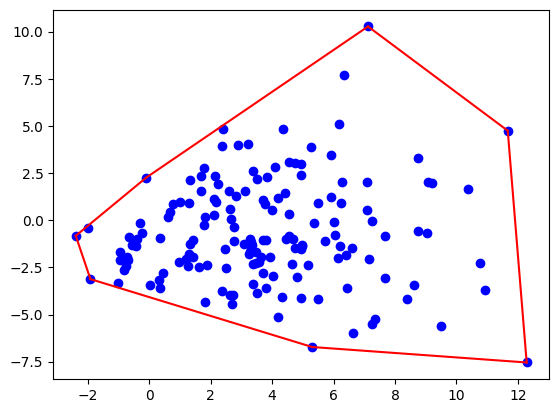

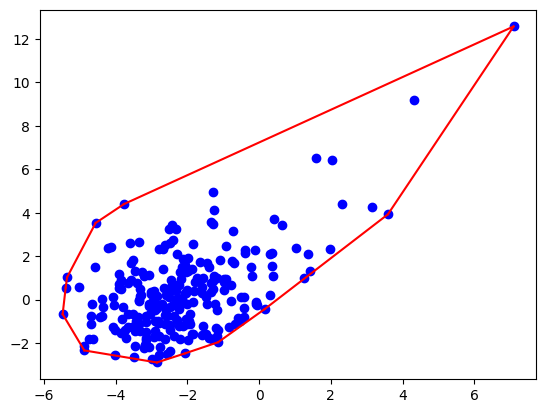

[(12.285019759541546, -7.543410169296517), (11.668714648329718, 4.748617202437218), (7.122953197708838, 10.275589121820708), (-0.09333138656719844, 2.260752006186767), (-2.385882758420641, -0.8241155709027862), (-1.9087689281363749, -3.1219458054787066), (5.307140022001161, -6.72341498355273), (12.285019759541546, -7.543410169296517)]
[(-2.8474315866961213, -2.8936475984252397), (-2.0591919425454, -2.4727877878040374), (-1.1429969265476934, -1.9621714940315211), (0.15513805946847606, -0.4380082282345959), (3.5912941186906333, 3.9263331552427028), (7.0933067141893185, 12.57319422866755), (-3.765414553258626, 4.398200493312165), (-4.555028840448128, 3.528786017879086), (-5.351618114936601, 1.026757858621048), (-5.3902563937741546, 0.5562555046609317), (-5.475243302544368, -0.6706367907181056), (-4.871239383480838, -2.3392147874209885), (-2.8474315866961213, -2.8936475984252397)]


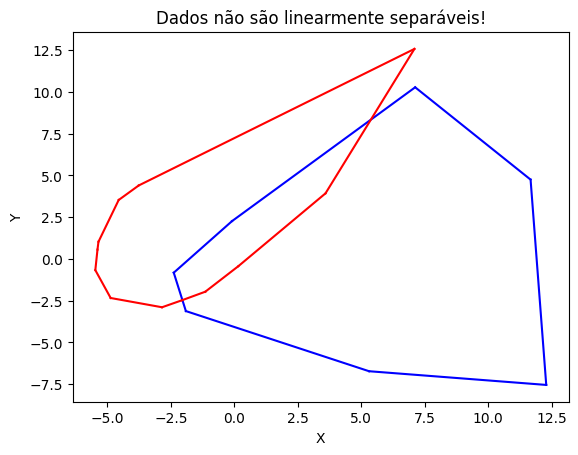

Os dados não são linearmente separáveis.


In [28]:
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA

# Carregando os dados
cancer = load_breast_cancer()
data = pd.DataFrame(cancer.data)

# Adicionando uma coluna com os rótulos
data['label'] = cancer.target

cancerPCA = apply_pca(data.drop(labels=['label'], axis=1))
cancerPCA['label'] = data['label']  # Adicionando o rótulo de volta após o PCA

cancerTest = cancerPCA.sample(frac = 0.3)
cancerTrain = cancerPCA.drop(cancerTest.index)

# Acessando as classes separadamente com base na coluna 'label'
cancerPCA0 = cancerTrain[cancerTrain['label'] == 0]
cancerPCA1 = cancerTrain[cancerTrain['label'] == 1]

# Convertendo para pontos
cancerPCA0Pts = [Ponto(row['Componente 1'], row['Componente 2']) for _, row in cancerPCA0.iterrows()]
cancerPCA1Pts = [Ponto(row['Componente 1'], row['Componente 2']) for _, row in cancerPCA1.iterrows()]

# Calculando e Plotando a envoltória convexa
cancerPCA0Env = graham_scan(cancerPCA0Pts)
plot_envoltoria(cancerPCA0Pts, cancerPCA0Env)

cancerPCA1Env = graham_scan(cancerPCA1Pts)
plot_envoltoria(cancerPCA1Pts, cancerPCA1Env)

separavel = verificar_separabilidade_linear(cancerPCA0Env, cancerPCA1Env)
plot_separabilidade(cancerPCA0Pts, cancerPCA1Pts)

if separavel:
    modelo = construir_modelo_linear(cancerPCA0Pts, cancerPCA1Pts)
    plot_modelo(cancerPCA0Pts, cancerPCA1Pts)

    label_cancer = 'label'
    precisao, revocacao, f1 = calcular_metricas(label_cancer, cancerTest, modelo, positive_label=0, negative_label=1)
    print(f"Precisão: {precisao:.2f}")
    print(f"Revocação: {revocacao:.2f}")
    print(f"F1-score: {f1:.2f}")
else:
    print('Os dados não são linearmente separáveis.')


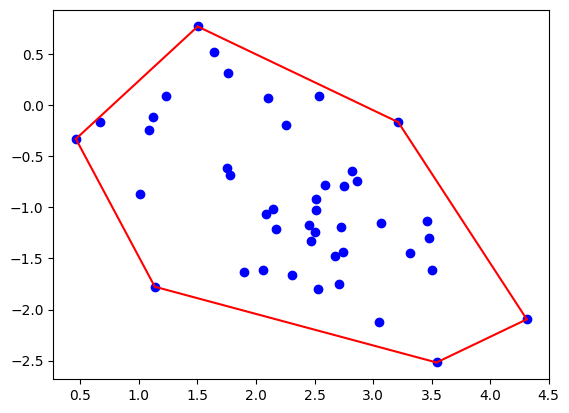

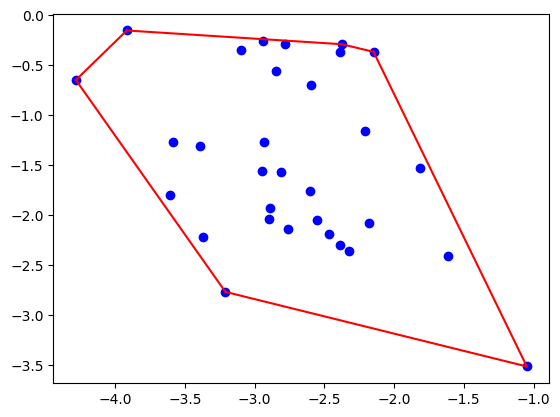

[(3.5419850819434693, -2.518343669306649), (4.312783906765564, -2.0959755753412637), (3.2149174747738245, -0.16699199499679107), (1.5021945006181927, 0.769432006431009), (0.4622091375160082, -0.33074213219227394), (1.1361661775610183, -1.777107392977638), (3.5419850819434693, -2.518343669306649)]
[(-1.0481818968536805, -3.5150896912197336), (-2.146811133816065, -0.3682549518864609), (-2.3744716280069245, -0.2919803515599947), (-3.9157537837118905, -0.1545825194417324), (-4.2806387787510864, -0.6496709640237044), (-3.208758164198024, -2.768919566047576), (-1.0481818968536805, -3.5150896912197336)]


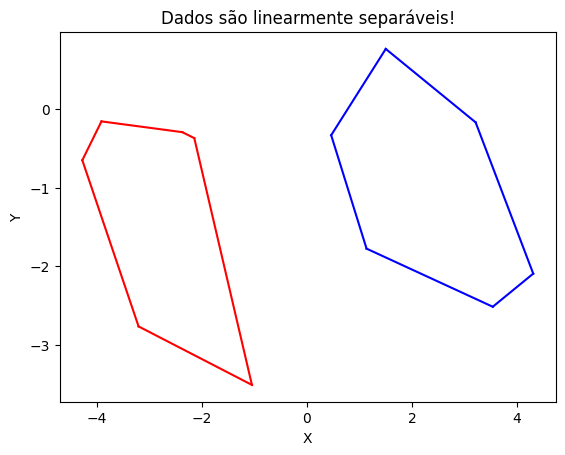

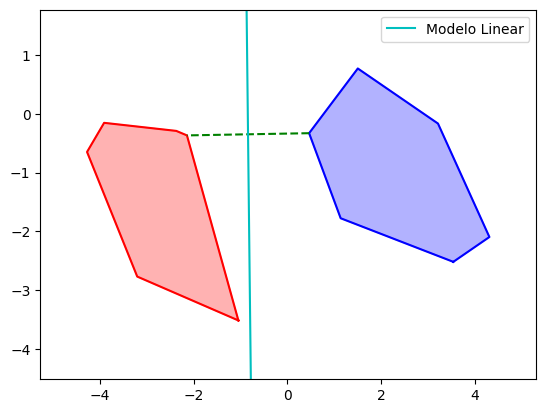

Precisão: 1.00
Revocação: 1.00
F1-score: 1.00


In [35]:
from sklearn.datasets import load_wine
import pandas as pd
from sklearn.decomposition import PCA

# Carregando os dados
wine = load_wine()
dataWine = pd.DataFrame(wine.data)

dataWine['label'] = wine.target

winePCA = apply_pca(dataWine.drop(labels=['label'], axis=1))

winePCA['label'] = dataWine['label']


# Dividindo os dados em conjuntos de treinamento e teste
wineTest = winePCA.sample(frac=0.3)
wineTrain = winePCA.drop(wineTest.index)

# Acessando as classes separadamente com base na coluna 'label'
winePCA0 = wineTrain[wineTrain['label'] == 0]
winePCA1 = wineTrain[wineTrain['label'] == 2]

# Convertendo para pontos
winePCA0Pts = [Ponto(row['Componente 1'], row['Componente 2']) for _, row in winePCA0.iterrows()]
winePCA1Pts = [Ponto(row['Componente 1'], row['Componente 2']) for _, row in winePCA1.iterrows()]

# Calculando e Plotando a envoltória convexa
winePCA0Env = graham_scan(winePCA0Pts)
plot_envoltoria(winePCA0Pts, winePCA0Env)

winePCA1Env = graham_scan(winePCA1Pts)
plot_envoltoria(winePCA1Pts, winePCA1Env)

separavel = verificar_separabilidade_linear(winePCA0Env, winePCA1Env)
plot_separabilidade(winePCA0Pts, winePCA1Pts)

if separavel:
    modelo = construir_modelo_linear(winePCA0Pts, winePCA1Pts)
    plot_modelo(winePCA0Pts, winePCA1Pts)
    label_wine = 'label'

    precisao, revocacao, f1 = calcular_metricas(label_wine, wineTest, modelo, positive_label=0, negative_label=2)
    print(f"Precisão: {precisao:.2f}")
    print(f"Revocação: {revocacao:.2f}")
    print(f"F1-score: {f1:.2f}")
else:
    print('Os dados não são linearmente separáveis.')


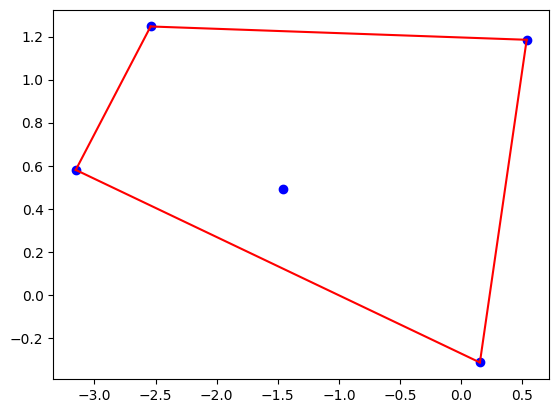

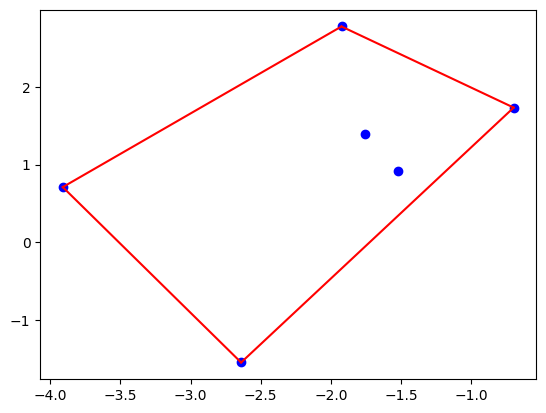

[(0.15319524045854244, -0.3143668802215969), (0.5359895637762238, 1.1851124901019587), (-2.5409358519092886, 1.2469292240352232), (-3.153239280772381, 0.5804699010834131), (0.15319524045854244, -0.3143668802215969)]
[(-2.6393873325185417, -1.544285819790608), (-0.6958792632401418, 1.7336679545001268), (-1.9235250630567033, 2.777092324217089), (-3.91117731353688, 0.7114499855363233), (-2.6393873325185417, -1.544285819790608)]


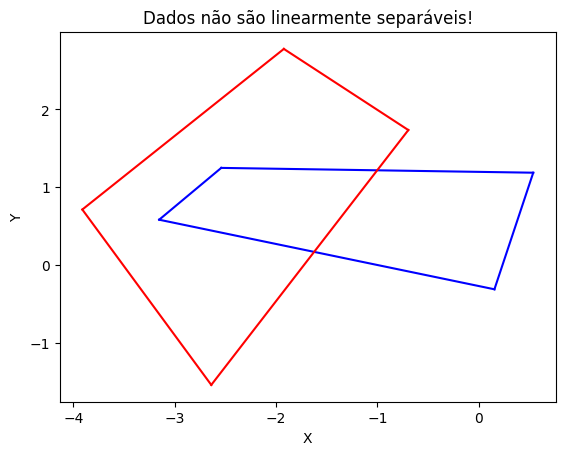

Os dados não são linearmente separáveis.


In [37]:
from sklearn.datasets import load_diabetes
import pandas as pd
from sklearn.decomposition import PCA


diabetes = load_diabetes()
data = pd.DataFrame(diabetes.data)

# Adicione uma coluna com os rótulos
data['label'] = diabetes.target

# Applying PCA for dimensionality reduction
diabetesPCA = apply_pca(data.drop(labels=['label'], axis=1))

diabetesPCA['label'] = data['label']

# Dividindo os dados em conjuntos de treinamento e teste
diabetesTest = diabetesPCA.sample(frac=0.3)
diabetesTrain = diabetesPCA.drop(diabetesTest.index)

# Accessing the classes separately based on the 'label' column
diabetesPCA0 = diabetesPCA[data['label'] == 90.0].reset_index(drop=True)
diabetesPCA1 = diabetesPCA[data['label'] == 72.0].reset_index(drop=True)

# Convertendo em pontos
diabetesPCA0 = [Ponto(row['Componente 1'], row['Componente 2']) for _, row in diabetesPCA0.iterrows()]
diabetesPCA1 = [Ponto(row['Componente 1'], row['Componente 2']) for _, row in diabetesPCA1.iterrows()]

# Plotando a envoltória convexa
diabetesPCA0Env = graham_scan(diabetesPCA0)
plot_envoltoria(diabetesPCA0, diabetesPCA0Env)

diabetesPCA1Env = graham_scan(diabetesPCA1)
plot_envoltoria(diabetesPCA1, diabetesPCA1Env)

verificar_separabilidade_linear(diabetesPCA0Env, diabetesPCA1Env)
plot_separabilidade(diabetesPCA0, diabetesPCA1)

modelo = construir_modelo_linear(diabetesPCA0, diabetesPCA1)

if modelo:
    precisao, revocacao, f1 = calcular_metricas(diabetesTrain, diabetesTest, modelo, 90, 72)
    print(f"Precisão: {precisao:.2f}")
    print(f"Revocação: {revocacao:.2f}")
    print(f"F1-score: {f1:.2f}")


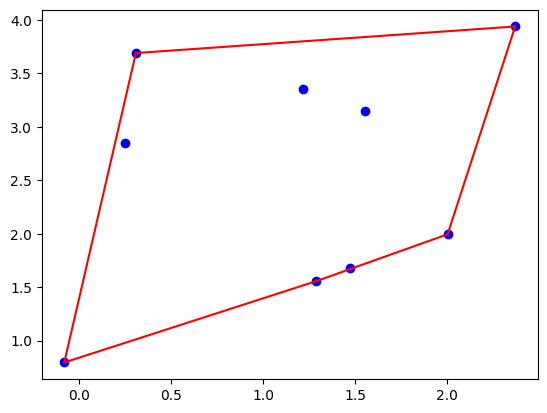

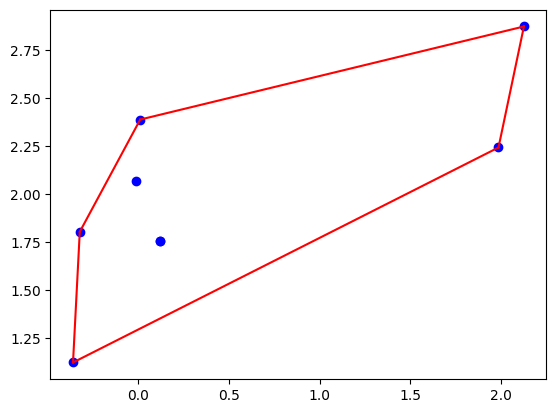

[(-0.08136419731161033, 0.7951427176191024), (1.283700328624321, 1.5537696497642115), (2.001463226655087, 1.9948388090434392), (2.3685094824572506, 3.939484073770715), (0.3077571693988254, 3.6907919255044783), (-0.08136419731161033, 0.7951427176191024)]
[(-0.36094936594458465, 1.1251728278882691), (1.9870033609072917, 2.2434204498181116), (2.1273616704539244, 2.872885141835017), (0.009916137818291915, 2.388747701931006), (-0.3236609922624985, 1.804774727223789), (-0.36094936594458465, 1.1251728278882691)]


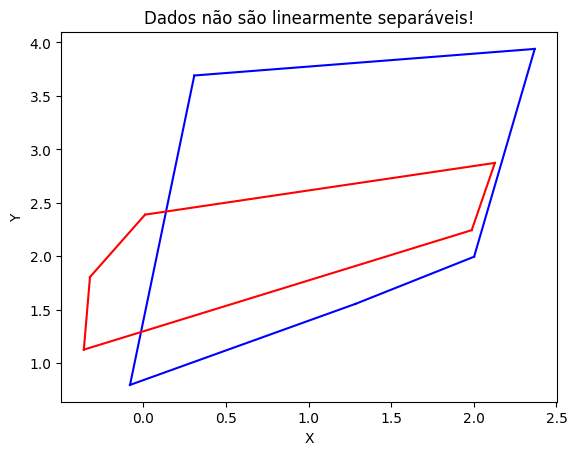

Os dados não são linearmente separáveis.


In [31]:
from sklearn.datasets import fetch_kddcup99
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import pandas as pd

kddcup99 = fetch_kddcup99()
data = pd.DataFrame(kddcup99.data)

# Adicione uma coluna com os rótulos
data['label'] = kddcup99.target

# Crie uma instância do LabelEncoder
label_encoder = LabelEncoder()

# Ajuste e transforme os rótulos
data['label'] = label_encoder.fit_transform(data['label'])

# Remova as colunas não númericas
colunas_a_remover = [0, 1, 2, 3]  # Índices das colunas a serem removidas
data = data.drop(data.columns[colunas_a_remover], axis=1)

# Use PCA for dimensionality reduction
kddcup99PCA = apply_pca(data.drop(labels=['label'], axis=1))

kddcup99PCA['label'] = data['label']

# Dividindo os dados em conjuntos de treinamento e teste
kddcup99Test = kddcup99PCA.sample(frac=0.3)
kddcup99Train = kddcup99PCA.drop(kddcup99Test.index)

# Acesse as classes separadamente com base na coluna 'label'
kddcup99PCA0 = kddcup99PCA[data['label'] == 7].reset_index(drop=True)
kddcup99PCA1 = kddcup99PCA[data['label'] == 2].reset_index(drop=True)

# Convertendo em pontos
kddcup99PCA0 = [Ponto(row['Componente 1'], row['Componente 2']) for index, row in kddcup99PCA0.iterrows()]
kddcup99PCA1 = [Ponto(row['Componente 1'], row['Componente 2']) for index, row in kddcup99PCA1.iterrows()]

# Plotando a envoltória convexa
kddcup99PCA0Env = graham_scan(kddcup99PCA0)
plot_envoltoria(kddcup99PCA0, kddcup99PCA0Env)

kddcup99PCA1Env = graham_scan(kddcup99PCA1)
plot_envoltoria(kddcup99PCA1, kddcup99PCA1Env)

verificar_separabilidade_linear(kddcup99PCA0Env, kddcup99PCA1Env)
plot_separabilidade(kddcup99PCA0, kddcup99PCA1)

modelo = construir_modelo_linear(kddcup99PCA0, kddcup99PCA1)

if modelo:
    precisao, revocacao, f1 = calcular_metricas('label', kddcup99Test, modelo, positive_label=7, negative_label=2)
    print(f"Precisão: {precisao:.2f}")
    print(f"Revocação: {revocacao:.2f}")
    print(f"F1-score: {f1:.2f}")


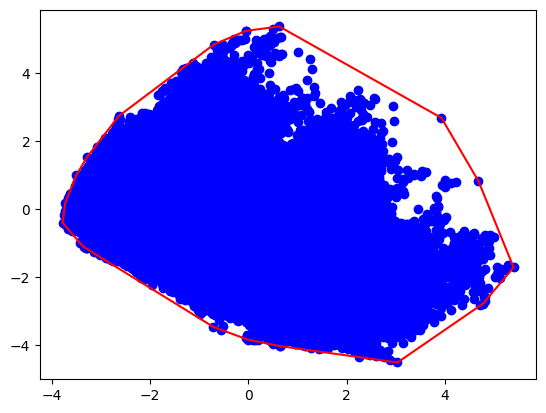

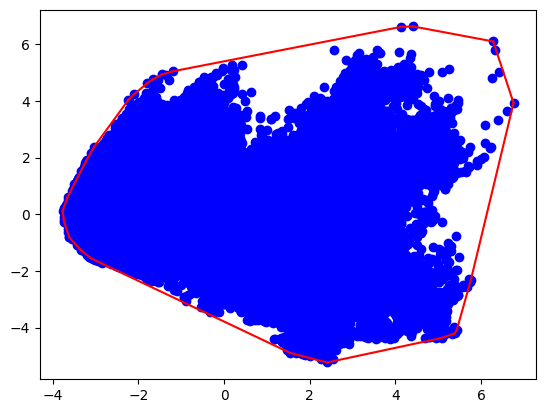

[(3.03202848933725, -4.524112760398666), (4.767132339445054, -2.7959242604334578), (4.820467130134044, -2.709540409681041), (5.394679774143916, -1.7196046028176857), (4.680983963152324, 0.8206877676374043), (3.9275052554137186, 2.685951343316481), (0.6272484041965632, 5.381466081471683), (-0.05234914100763763, 5.251625115788591), (-0.7065608414736297, 4.848922248768512), (-2.640870247431014, 2.7385185791769064), (-3.280754143903734, 1.536396261049075), (-3.504439282353811, 0.9963033671188848), (-3.7281051319551968, 0.17912593530238963), (-3.760434427070892, -0.1617290282188119), (-3.7816509622201435, -0.40571598503430784), (-3.422727292429906, -1.0106675369602924), (-3.353778098701064, -1.117148902821142), (-0.7118506605860755, -3.4773034989884706), (-0.015026606090213246, -3.8495341120218227), (0.6483024074537246, -4.04304300928546), (3.03202848933725, -4.524112760398666)]
[(2.4053293346991618, -5.23507379281403), (5.078343554720125, -4.369444005886599), (5.3826330370278, -4.208122246

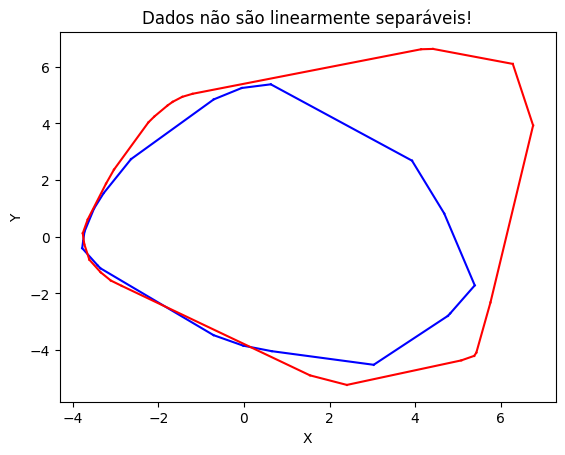

Os dados não são linearmente separáveis.


In [32]:
from sklearn.datasets import fetch_covtype

covtype = fetch_covtype()

data = pd.DataFrame(covtype.data)
data['label'] = covtype.target

# Aplicando PCA
covtypePCA = apply_pca(data.drop(labels=['label'], axis=1))
covtypePCA['label'] = data['label']

# Dividindo os dados em conjuntos de treinamento e teste
covtypeTest = covtypePCA.sample(frac=0.3)
covtypeTrain = covtypePCA.drop(covtypeTest.index)

# Acessando as classes separadamente com base na coluna 'label'
covtypePCA0 = covtypePCA[data['label'] == 1].reset_index(drop=True)
covtypePCA1 = covtypePCA[data['label'] == 2].reset_index(drop=True)

# Convertendo em pontos
covtypePCA0 = [Ponto(row['Componente 1'], row['Componente 2']) for index, row in covtypePCA0.iterrows()]
covtypePCA1 = [Ponto(row['Componente 1'], row['Componente 2']) for index, row in covtypePCA1.iterrows()]

# Plotando a envoltória convexa
covtypePCA0Env = graham_scan(covtypePCA0)
plot_envoltoria(covtypePCA0, covtypePCA0Env)

covtypePCA1Env = graham_scan(covtypePCA1)
plot_envoltoria(covtypePCA1, covtypePCA1Env)

verificar_separabilidade_linear(covtypePCA0Env, covtypePCA1Env)
plot_separabilidade(covtypePCA0, covtypePCA1)

modelo = construir_modelo_linear(covtypePCA0, covtypePCA1)

if modelo:
    precisao, revocacao, f1 = calcular_metricas('label', covtypeTest, modelo, positive_label=1, negative_label=2)
    print(f"Precisão: {precisao:.2f}")
    print(f"Revocação: {revocacao:.2f}")
    print(f"F1-score: {f1:.2f}")


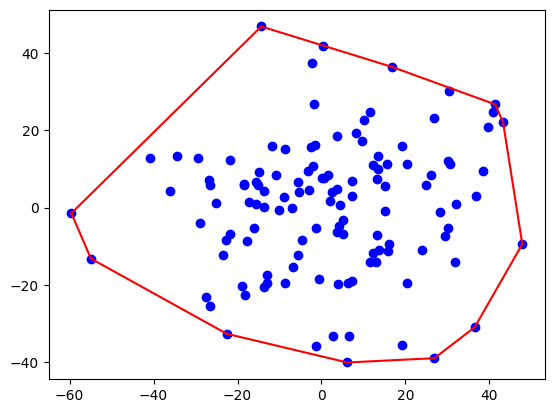

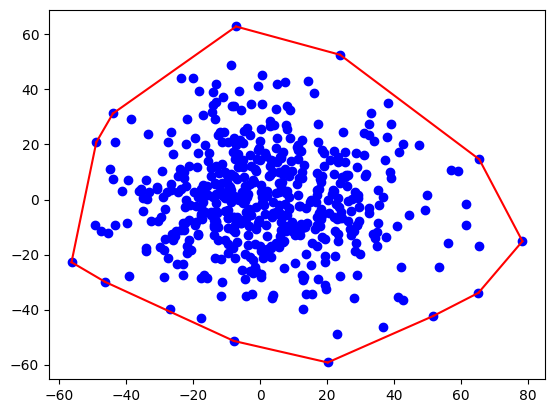

[(6.148714065551758, -40.01921081542969), (26.899564743041992, -38.91570281982422), (36.50579833984375, -30.90756607055664), (47.845008850097656, -9.41824722290039), (43.26771545410156, 22.032344818115234), (41.39779281616211, 26.69209098815918), (16.79871940612793, 36.386322021484375), (-14.34133243560791, 46.837257385253906), (-59.57978057861328, -1.4377810955047607), (-54.92536544799805, -13.173683166503906), (-22.569669723510742, -32.60499954223633), (6.148714065551758, -40.01921081542969)]
[(20.200740814208984, -59.22120666503906), (51.76608657836914, -42.31489944458008), (65.23971557617188, -33.92292785644531), (78.39729309082031, -15.160890579223633), (65.49610900878906, 14.59427547454834), (23.879146575927734, 52.600101470947266), (-7.219131946563721, 62.88508987426758), (-44.012001037597656, 31.26657485961914), (-48.9884147644043, 20.82372283935547), (-56.397682189941406, -22.77681541442871), (-46.4128303527832, -29.898700714111328), (-7.865787982940674, -51.3991584777832), (2

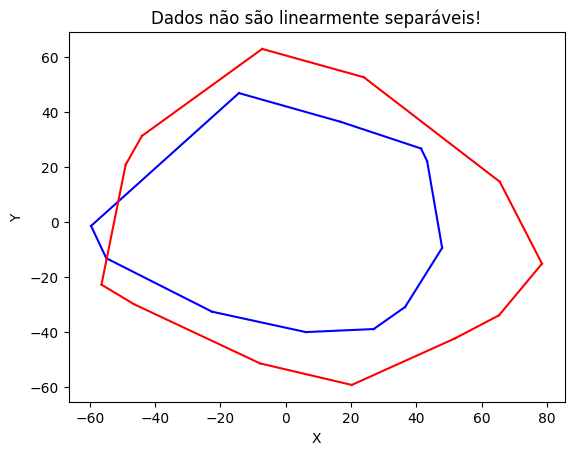

Os dados não são linearmente separáveis.


In [33]:
from sklearn.datasets import fetch_lfw_people

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

data = pd.DataFrame(lfw_people.data)

# Adicione uma coluna com os rótulos
data['label'] = lfw_people.target

# Aplicando PCA
lfw_peoplePCA = apply_pca(data.drop(labels=['label'], axis=1))
lfw_peoplePCA['label'] = data['label']

# Dividindo os dados em conjuntos de treinamento e teste
lfw_peopleTest = lfw_peoplePCA.sample(frac=0.3)
lfw_peopleTrain = lfw_peoplePCA.drop(lfw_peopleTest.index)

# Acessando as classes separadamente com base na coluna 'label'
lfw_peoplePCA0 = lfw_peoplePCA[data['label'] == 0].reset_index(drop=True)
lfw_peoplePCA1 = lfw_peoplePCA[data['label'] == 1].reset_index(drop=True)

# Convertendo em pontos
lfw_peoplePCA0 = [Ponto(row['Componente 1'], row['Componente 2']) for index, row in lfw_peoplePCA0.iterrows()]
lfw_peoplePCA1 = [Ponto(row['Componente 1'], row['Componente 2']) for index, row in lfw_peoplePCA1.iterrows()]

# Plotando a envoltória convexa
lfw_peoplePCA0Env = graham_scan(lfw_peoplePCA0)
plot_envoltoria(lfw_peoplePCA0, lfw_peoplePCA0Env)

lfw_peoplePCA1Env = graham_scan(lfw_peoplePCA1)
plot_envoltoria(lfw_peoplePCA1, lfw_peoplePCA1Env)

verificar_separabilidade_linear(lfw_peoplePCA0Env, lfw_peoplePCA1Env)
plot_separabilidade(lfw_peoplePCA0, lfw_peoplePCA1)

modelo = construir_modelo_linear(lfw_peoplePCA0, lfw_peoplePCA1)

if modelo:
    precisao, revocacao, f1 = calcular_metricas('label', lfw_peopleTest, modelo, positive_label=0, negative_label=1)
    print(f"Precisão: {precisao:.2f}")
    print(f"Revocação: {revocacao:.2f}")
    print(f"F1-score: {f1:.2f}")



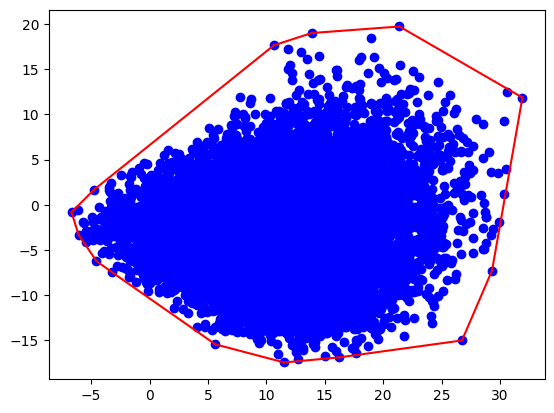

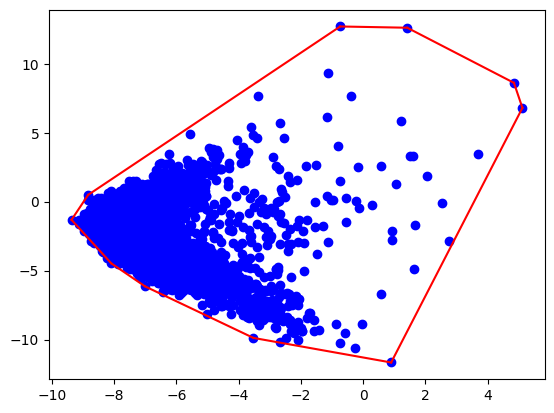

[(11.525018158723526, -17.44139807441677), (16.239934541271502, -16.877376209345414), (26.750812444196285, -15.004410311835642), (29.32568485097907, -7.2693561977509376), (31.929033723848438, 11.866388855008887), (21.39561742478963, 19.73083344937483), (13.879021015714466, 19.003954413520614), (10.65353510058148, 17.653639411522256), (-4.756160914306539, 1.6728606433572777), (-6.685290633017142, -0.8145118399230199), (-6.082347152400056, -3.312617964319601), (-4.546114705545542, -6.224658498300106), (-3.186765045059135, -7.485487873895057), (5.637174152016529, -15.435946512193366), (11.525018158723526, -17.44139807441677)]
[(0.9014476220582972, -11.661978156565047), (5.120737473025844, 6.7996772667228464), (4.847651596591112, 8.614815170158561), (1.4174734663206154, 12.610696419562316), (-0.7367614836676029, 12.701413635937458), (-8.837569739251977, 0.4935511131015032), (-9.373713275273527, -1.3180312562194414), (-8.094093392692262, -4.477785653310312), (-7.011417070312925, -6.14167083

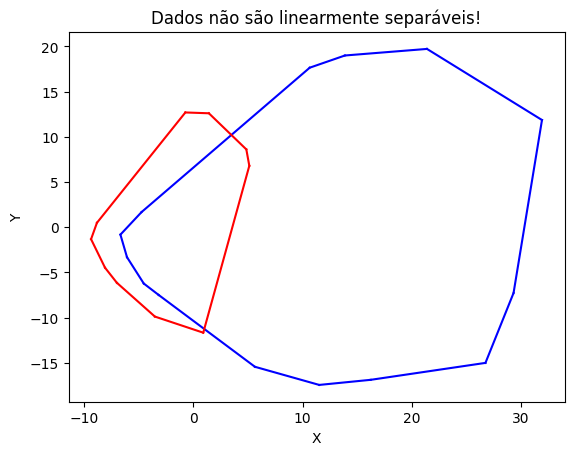

Os dados não são linearmente separáveis.


In [34]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, parser='auto')

data = pd.DataFrame(mnist.data)
data['label'] = mnist.target

# Aplicando PCA
mnistPCA = apply_pca(data.drop(labels=['label'], axis=1))
mnistPCA['label'] = data['label']

# Dividindo os dados em conjuntos de treinamento e teste
mnistTest = mnistPCA.sample(frac=0.3)
mnistTrain = mnistPCA.drop(mnistTest.index)

# Acessando as classes separadamente com base na coluna 'label'
mnistPCA0 = mnistPCA[data['label'] == '0'].reset_index(drop=True)
mnistPCA1 = mnistPCA[data['label'] == '1'].reset_index(drop=True)

# Convertendo em pontos
mnistPCA0 = [Ponto(row['Componente 1'], row['Componente 2']) for _, row in mnistPCA0.iterrows()]
mnistPCA1 = [Ponto(row['Componente 1'], row['Componente 2']) for _, row in mnistPCA1.iterrows()]

# Plotando a envoltória convexa
mnistPCA0Env = graham_scan(mnistPCA0)
plot_envoltoria(mnistPCA0, mnistPCA0Env)

mnistPCA1Env = graham_scan(mnistPCA1)
plot_envoltoria(mnistPCA1, mnistPCA1Env)

verificar_separabilidade_linear(mnistPCA0Env, mnistPCA1Env)
plot_separabilidade(mnistPCA0, mnistPCA1)

modelo = construir_modelo_linear(mnistPCA0, mnistPCA1)

if modelo:
    precisao, revocacao, f1 = calcular_metricas('label', mnistTest, modelo, positive_label='0', negative_label='1')
    print(f"Precisão: {precisao:.2f}")
    print(f"Revocação: {revocacao:.2f}")
    print(f"F1-score: {f1:.2f}")
